# A / B test
This project is an A/B test about a mobile game, Cookie Cats. Data is obtained from Kaggle: https://www.kaggle.com/yufengsui/mobile-games-ab-testing#

Let's assume we haven't looked at the data and want to build up the hypothesis. My client company is developing a new mobile game called Cookie Cats. Their main interest is whether the return rate of new users will change significantly after they add a gate (an obstacle) at a high(or median) level. 

This question is ideal for conducting an experimental study. Based on the above information, we understand the following components in a potential hypothesis:
1. The KPI that interests my client is new user's return rate, probably both short-term and long-term return rates
2. The interuption(action) my client intends to make is to add a gate at a high (or median) level. Based on common sense, adding a gate in the middle of a game encourages game players to continue playing rather than falling into boredom. So after discussing with my client (assume this happens), the question changes slightly to: 

Whether adding a gate (an obstacle) at median level has a higher return rate than adding a gate at a higher level. 

Let's continue quantifying the hypothesis.
3. So my client wants to try out adding the gate at level 30 and 40 first. Here comes the null hypothesis and treatment hypothesis. 
4. They have set up the short-term rate to be after 1 day and the long-term one to be after 7 days. 
5. They also don't want to just look at the p-value or the significance only (Type I alpha error), so I will also provide Type II error, Beta error for their considerations. 

All in all, the final hypothesis is:


Hypothesis 1: Whether adding a gate at level 40 has a higher return rate than adding a gate at level 30 after 1 day;
Hypothesis 2: Whether adding a gate at level 40 has a higher return rate than adding a gate at level 30 after 7 days.



### A brief overview of the data sets


So my client provides me following variables for analysis: 

1.userid:A unique number that identifies each player.

2.version:Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

3.sum_gamerounds:The number of game rounds played by the player during the first 14 days after install.

4.retention_1:Did the player come back and play 1 day after installing?

5.retention_7:Did the player come back and play 7 days after installing?

### Import modules and load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

In [2]:
df=pd.read_csv('/Users/jianfengbei/Google Drive/2020 study/portfolio -  python - A_B test/cookie_cats.csv')

In [3]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [4]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Check for duplicates

In [5]:
df.duplicated().sum()

0

### Building function(s)

In [6]:
def A_B_test(df, hypo_var):
    '''
    make pivot table for key variables
    plot distributions before and after standardization
    plot the distribution of group difference
    run A/B test and calculate statistical power'''
    pivot_table=df.pivot_table(values=hypo_var,index='version',aggfunc=np.sum)

    pivot_table['total']=df.pivot_table(values=hypo_var,index='version',aggfunc=lambda x: len(x))
    pivot_table['avg_rounds']=df.pivot_table(values='sum_gamerounds',index='version',aggfunc=np.mean)
    pivot_table['rate']=df.pivot_table(values=hypo_var,index='version')
    print(pivot_table)

    print('                                                                            ')    
    print('----------------------------------------------------------------------------')
    print('Distribution of the control & treatment groups BEFORE standardization:')
    A_k=pivot_table.iloc[0,0]
    A_n = pivot_table.iloc[0,1]
    A_p=pivot_table.iloc[0,3]
    B_k=pivot_table.iloc[1,0]
    B_n = pivot_table.iloc[1,1]
    B_p=pivot_table.iloc[1,3]
    #plot binomial distribution
    fix,ax=plt.subplots(figsize=(12,6))
    x_A=np.linspace(A_k-399,A_k+400,800)
    y_A=scs.binom(A_n,A_p).pmf(x_A)
    ax.bar(x_A,y_A,alpha=0.5)
    ax.axvline(x=A_p * A_n, c='red',alpha=0.75,linestyle='--')
    # source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html
    x_B=np.linspace(B_k-399,B_k+400,800)
    y_B=scs.binom(B_n,B_p).pmf(x_B)
    ax.bar(x_B,y_B,alpha=0.5)
    ax.axvline(x=B_p * B_n, c='purple',alpha=0.75,linestyle='--')
    plt.xlabel('Number of success')
    plt.ylabel('Probability')
    plt.show()
    print('                                      Figure 1                              ')    
    
    print('                                                                            ')    
    print('----------------------------------------------------------------------------')
    print('Distribution of the control & treatment groups AFTER standardization:')
    A_se = np.sqrt(A_p *(1-A_p))/np.sqrt(A_n)
    B_se = np.sqrt(B_p *(1-B_p))/np.sqrt(B_n)
    #plot normal distribution
    fix,ax=plt.subplots(figsize=(12,6))
    x = np.linspace(A_p-0.02,A_p+0.015,800) #!!!!!
    y_A=scs.norm(A_p,A_se).pdf(x) 
    ax.plot(x,y_A)
    ax.axvline(x=A_p, c='blue',alpha=0.5,linestyle='--')

    y_B=scs.norm(B_p,B_se).pdf(x)
    ax.plot(x,y_B)
    ax.axvline(x=B_p, c='orange',alpha=0.5,linestyle='--')
    plt.ylabel('PDF')
    plt.show()
    print('                                      Figure 2                              ')    


    print('                                                                            ')    
    print('----------------------------------------------------------------------------')
    print('Distribution of group difference AFTER standardization:')
    # estimated difference
    d_hat = A_p-B_p
    # variance/se of the sum
    d_p_se=np.sqrt(A_se*A_se+B_se*B_se)
    
    fix,ax=plt.subplots(figsize=(12,6))
    x_d = np.linspace(d_hat-0.02,d_hat+0.015,800)
    y_d=scs.norm(d_hat,d_p_se).pdf(x_d) 
    ax.plot(x_d,y_d)
    ax.axvline(x=scs.norm(d_hat,d_p_se).ppf(0.025), c='blue',alpha=0.5,linestyle='--')
    ax.axvline(x=scs.norm(d_hat,d_p_se).ppf(0.975), c='blue',alpha=0.5,linestyle='--')
    y_d_null=scs.norm(0,d_p_se).pdf(x_d) 
    ax.plot(x_d,y_d_null)
    ax.axvline(x=scs.norm(0,d_p_se).ppf(0.025), c='orange',alpha=0.5,linestyle='--')
    ax.axvline(x=scs.norm(0,d_p_se).ppf(0.975), c='orange',alpha=0.5,linestyle='--')
    plt.ylabel('PDF')
    plt.show()
    print('                                      Figure 3                              ')    
    

    print('P-value for this A/B test is:')
    print(2*scs.norm(d_hat,d_p_se).cdf(0))
    print("It's statistical power is:")
    print((1-scs.norm(d_hat,d_p_se).cdf(scs.norm(0,1).ppf(0.975)-d_hat*d_p_se))+scs.norm(d_hat,d_p_se).cdf(scs.norm(0,1).ppf(0.025)-d_hat*d_p_se))


## Run A/B test

         retention_1  total  avg_rounds      rate
version                                          
gate_30      20034.0  44700   52.456264  0.448188
gate_40      20119.0  45489   51.298776  0.442283
                                                                            
----------------------------------------------------------------------------
Distribution of the control & treatment groups BEFORE standardization:


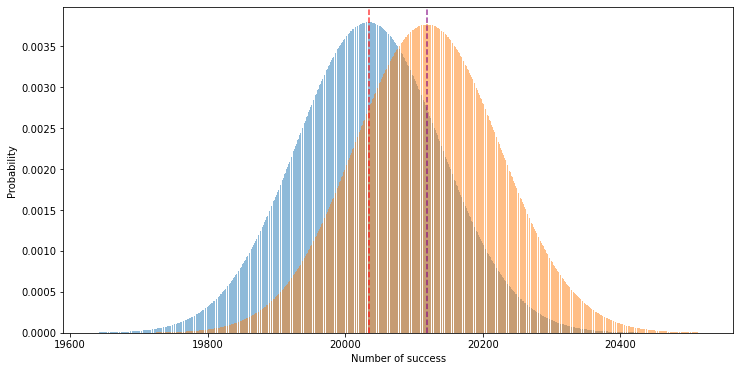

                                      Figure 1                              
                                                                            
----------------------------------------------------------------------------
Distribution of the control & treatment groups AFTER standardization:


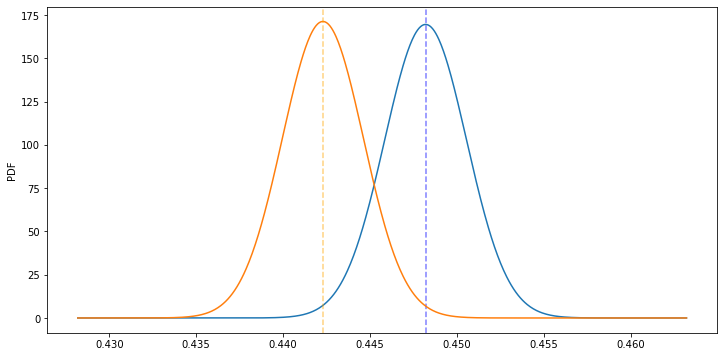

                                      Figure 2                              
                                                                            
----------------------------------------------------------------------------
Distribution of group difference AFTER standardization:


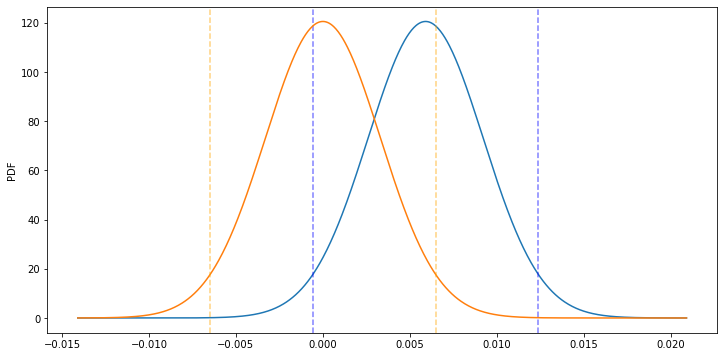

                                      Figure 3                              
P-value for this A/B test is:
0.07440786052349997
It's statistical power is:
0.0


In [7]:
A_B_test(df, 'retention_1')

         retention_7  total  avg_rounds      rate
version                                          
gate_30       8502.0  44700   52.456264  0.190201
gate_40       8279.0  45489   51.298776  0.182000
                                                                            
----------------------------------------------------------------------------
Distribution of the control & treatment groups BEFORE standardization:


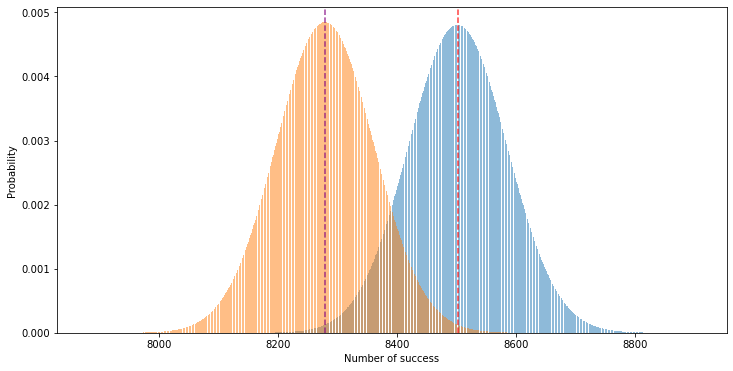

                                      Figure 1                              
                                                                            
----------------------------------------------------------------------------
Distribution of the control & treatment groups AFTER standardization:


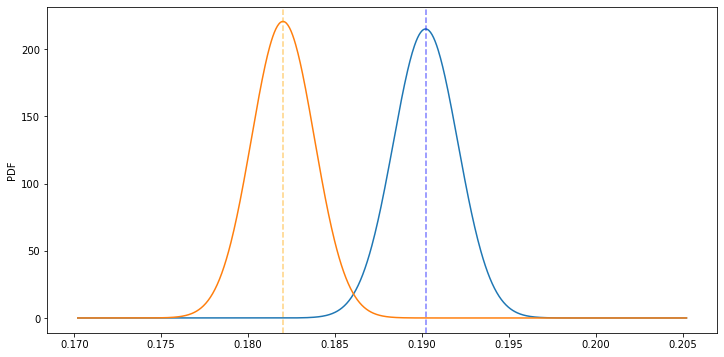

                                      Figure 2                              
                                                                            
----------------------------------------------------------------------------
Distribution of group difference AFTER standardization:


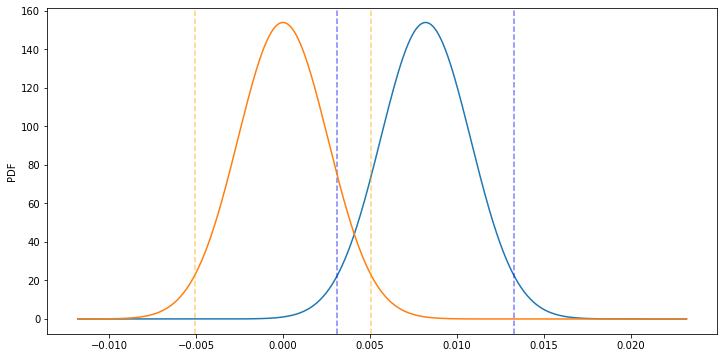

                                      Figure 3                              
P-value for this A/B test is:
0.0015558255737072547
It's statistical power is:
0.0


In [8]:
A_B_test(df, 'retention_7')

It looks like both return rates show little difference between control group and the experimental group, though the return rate after 7 days is slightly higher than that of the rate after 1 day. 

The group difference after 7 days is significantly different from zero, but the statistical power is low, so there is no high percentage that this difference is high enough to make the change. 
Suggestions would be: consider setting the gate at different levels in a wider range before conducting the next round of A/B test. 